## Assignment for Week 5 - Neural Network

### Project:
#### Neural Networks
Credit Card Fraud data: https://www.kaggle.com/mlg-ulb/creditcardfraud/

- Make at least 2 EDA plots – histograms, correlation plots (df.corr() in python/pandas, and seaborn’s heatmap can plot it), scatter/line plots, etc.
- Use a neural net to predict if a transaction is fraud or not (you will have to change the loss function from mse/mae to something for binary classification)
- Plot the training and validation loss
- Report the performance on the training and test set with accuracy and confusion matrices
- Write some interpretation of all your results/plots


---

# 1 Setup

## 1.A Sanity Check of Provided Data File

Prior to importing any data, we perform a few checks against the file:
* What is the approximate size of the file (will our current configuration
  support the given quantity of data)?
* What is the content of the file and does it use the correct line endings?
* How many rows (lines) are in the file (can be used to double-check that
  the full dataset is loaded by Pandas)?
* Does the data have a header row?


In [1]:
%%bash
declare -a DATA_FILES=("data/creditcard.csv")

for FILE in "${DATA_FILES[@]}"; do
    if [ -f "${FILE}" ] ; then
        echo "${FILE}:"
        echo "    Data file size:      $(du -h ${FILE} | awk '{print $1;}')"
        echo "    Data file type:      $(file --brief ${FILE})"
        echo "    Number of lines:     $(wc -l ${FILE} | awk '{print $1;}')"
        echo "    Data header row?     $(head -n 1 ${FILE})"
    else
        echo "${FILE}: NOT FOUND"
    fi
done

data/creditcard.csv:
    Data file size:      144M
    Data file type:      CSV text
    Number of lines:     284808
    Data header row?     "Time","V1","V2","V3","V4","V5","V6","V7","V8","V9","V10","V11","V12","V13","V14","V15","V16","V17","V18","V19","V20","V21","V22","V23","V24","V25","V26","V27","V28","Amount","Class"


## 1.B Python/Jupyter Setup

We organize the imports at the begining of the notebook, similar to a
"traditional" Python file.  This is a personal preference.

Furthermore, we prefer the Python `logging` module over "raw" print statements
to stdout.

In [2]:
import logging
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import os.path
import pandas as pd
import shutil

import keras
import keras.callbacks
import keras.layers
import keras.models
import keras.optimizers
import keras.regularizers
import keras_tuner as kt

import seaborn as sns
import sklearn.compose
import sklearn.manifold
import sklearn.metrics
import sklearn.neural_network
import sklearn.preprocessing
import sklearn.utils

# Activate the 'inline' backend such that plots are displayed directly
# after the cell containing the plot command
%matplotlib inline

# Display up to 100 rows
pd.options.display.max_rows = 100

# Set up logging ...
logging.basicConfig(format='%(asctime)s - %(levelname)-6s - %(name)10s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.DEBUG)
logging.getLogger('matplotlib').setLevel(logging.ERROR)

LOGGER = logging.getLogger('MSDS-680')

RANDOM_SEED = 42
LEGITIMATE  = 0
FRAUD       = 1
MAX_EPOCHS  = 50
KERAS_PROJECT_PATH  = './keras/credit-card-fraud'
KERAS_BATCH_SIZE    = 150

## 1.C Import the Data


In [3]:
credit_df = pd.read_csv('data/creditcard.csv')
LOGGER.info(f'credit_df.shape ==> {credit_df.shape[0]} rows x {credit_df.shape[1]} cols')
credit_df.head()

2022-02-14 00:19:25 - INFO   -   MSDS-680 - credit_df.shape ==> 284807 rows x 31 cols


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

# 2 Exploratory Data Analysis

## 2.A Data Overview

From Kaggle.com (n.d.):

    [the data set] contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

    Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

The original features have been obscured along new axes corresponding to the
principle components V1 - V28.


In [5]:
credit_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,...,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


## 2.B Class Distribution

The histogram below clearly shows a significant imbalance between the
*Legitimate* class and the *Fraud* class.

2022-02-14 00:19:26 - INFO   -   MSDS-680 - Size of data: 284807 ... 99.83% legitimate, 0.17% fraud


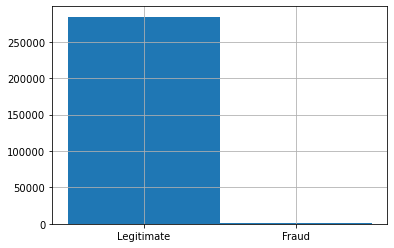

In [6]:
class_pcts = credit_df['Class'].value_counts(normalize=True).values
LOGGER.info(f'Size of data: {credit_df.shape[0]} ... {class_pcts[LEGITIMATE]:.2%} legitimate, {class_pcts[FRAUD]:.2%} fraud')
credit_df['Class'].hist(bins=2)
_ = plt.xticks(ticks=(0.25, 0.75), labels=['Legitimate', 'Fraud'])


## 2.C Feature-to-Class Correlation

With the imbalanced data, we don't see intra-axis correlation.

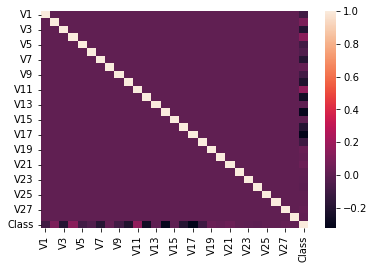

In [7]:
_ =sns.heatmap(credit_df.drop(['Time', 'Amount'], axis='columns').corr())

## 2.D Analysis of Amount and Time

Inspired by Valkov (2017), we overlay a histogram of Fraud amounts with
Legitimate transaction amounts.  It appears that Fraud amounts tend to remain
in the `1 - 2500` range while Legitimate transactions range from `1 - 20,000`.
Since the ranges overlap, it does not appear that we can use `Amount` as a 
descriminator.

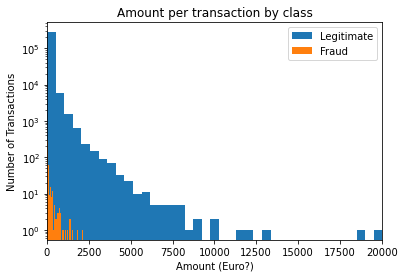

In [8]:
fig, ax = plt.subplots()
ax.set_title('Amount per transaction by class')

ax.hist(credit_df[credit_df['Class'] == LEGITIMATE].Amount, bins = 50, label='Legitimate')
ax.hist(credit_df[credit_df['Class'] == FRAUD].Amount, bins = 50, label='Fraud')
ax.legend()

plt.xlabel('Amount (Euro?)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show()

Likewise, it appears that `Time` does not appear to play a role in determining
Fraud vs Legitimate transaction.

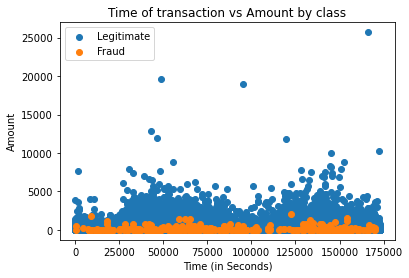

In [9]:
f, ax = plt.subplots()
ax.set_title('Time of transaction vs Amount by class')

ax.scatter(credit_df[credit_df['Class'] == LEGITIMATE].Time,
           credit_df[credit_df['Class'] == LEGITIMATE].Amount,
           label='Legitimate')
ax.scatter(credit_df[credit_df['Class'] == FRAUD].Time,
           credit_df[credit_df['Class'] == FRAUD].Amount,
           label='Fraud')
ax.legend()

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

# 3 Artificial Neural Network (ANN)

## 3.A Data Preparation

## 3.A.1 Feature Transformation(s)

Below, we identify columns that will become features and which column will be
used as labels.

In [10]:
# Identify the label column:
label_column = 'Class'

not_feature_columns = [label_column, 'Time', 'Amount']

# All other columns are inputs (features)
feature_columns = [c for c in credit_df.columns if c not in not_feature_columns]

transformer = sklearn.preprocessing.MinMaxScaler()



## 3.B Train / Test Split

### 3.B.1 Train / Test Split - Unbalanced Data

The data is imbalanced, but `sklearn.model_selection.train_test_split` correctly
splits the data to produce training and test data that represents both cases
proportionately.

In [11]:

# X = input, y = labels
X = credit_df[feature_columns].values
y = credit_df[label_column].values

# This will randomly split the data according to the provided ratio (0.2)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)


LOGGER.info(f'X_train.shape ==> {X_train.shape[0]} rows x {X_train.shape[1]} cols')
LOGGER.info(f'X_test.shape  ==> {X_test.shape[0]}  rows x {X_test.shape[1]} cols')

LOGGER.info(f'y_train.shape ==> {y_train.shape[0]} rows')
LOGGER.info(f'y_test.shape  ==> {y_test.shape[0]}  rows')

def log_data_proportion(data, data_name='data'):
    fraud_count = np.count_nonzero(data)
    legit_count = len(data) - fraud_count

    fraud_pct   = fraud_count / len(data)
    legit_pct   = legit_count / len(data)

    LOGGER.info(f'Size of {data_name}: {len(data)} ... {legit_pct:.2%} legitimate, {fraud_pct:.2%} fraud')

log_data_proportion(y_train, 'training data')
log_data_proportion(y_test, 'test data')

# Transformed X_train data
Xt_train = transformer.fit_transform(X_train)
Xt_test  = transformer.transform(X_test)


2022-02-14 00:19:33 - INFO   -   MSDS-680 - X_train.shape ==> 227845 rows x 28 cols
2022-02-14 00:19:33 - INFO   -   MSDS-680 - X_test.shape  ==> 56962  rows x 28 cols
2022-02-14 00:19:33 - INFO   -   MSDS-680 - y_train.shape ==> 227845 rows
2022-02-14 00:19:33 - INFO   -   MSDS-680 - y_test.shape  ==> 56962  rows
2022-02-14 00:19:33 - INFO   -   MSDS-680 - Size of training data: 227845 ... 99.83% legitimate, 0.17% fraud
2022-02-14 00:19:33 - INFO   -   MSDS-680 - Size of test data: 56962 ... 99.83% legitimate, 0.17% fraud


### 3.B.2 Train / Test Split - Balanced Data

Under-sample the majority (legitimate) case

In [12]:
num_fraud = credit_df[credit_df['Class'] == FRAUD].shape[0]

balanced_df = pd.concat((credit_df[credit_df['Class'] == LEGITIMATE].sample(n=num_fraud,
                                                                            axis='index',
                                                                            random_state=RANDOM_SEED),
                         credit_df[credit_df['Class'] == FRAUD]))

# At this point, balanced_df contains all LEGITIMATE in a contiguous block
# followed by FRAUD in a contiguous block ... randomly shuffle the DataFrame
balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)


# X = input, y = labels
X_balanced = balanced_df[feature_columns].values
y_balanced = balanced_df[label_column].values

# This will randomly split the data according to the provided ratio (0.2)
X_balanced_train, X_balanced_test, y_balanced_train, y_balanced_test = sklearn.model_selection.train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=RANDOM_SEED)

LOGGER.info(f'X_balanced_train.shape ==> {X_balanced_train.shape[0]} rows x {X_balanced_train.shape[1]} cols')
LOGGER.info(f'X_balanced_test.shape  ==> {X_balanced_test.shape[0]}  rows x {X_balanced_test.shape[1]} cols')

LOGGER.info(f'y_balanced_train.shape ==> {y_balanced_train.shape[0]} rows')
LOGGER.info(f'y_balanced_test.shape  ==> {y_balanced_test.shape[0]}  rows')

log_data_proportion(y_balanced_train, 'balanced training data')
log_data_proportion(y_balanced_test, 'balanced test data')

# Transformed X_train data
Xt_balanced_train = transformer.fit_transform(X_balanced_train)
Xt_balanced_test  = transformer.transform(X_balanced_test)


2022-02-14 00:19:33 - INFO   -   MSDS-680 - X_balanced_train.shape ==> 787 rows x 28 cols
2022-02-14 00:19:33 - INFO   -   MSDS-680 - X_balanced_test.shape  ==> 197  rows x 28 cols
2022-02-14 00:19:33 - INFO   -   MSDS-680 - y_balanced_train.shape ==> 787 rows
2022-02-14 00:19:33 - INFO   -   MSDS-680 - y_balanced_test.shape  ==> 197  rows
2022-02-14 00:19:33 - INFO   -   MSDS-680 - Size of balanced training data: 787 ... 49.81% legitimate, 50.19% fraud
2022-02-14 00:19:33 - INFO   -   MSDS-680 - Size of balanced test data: 197 ... 50.76% legitimate, 49.24% fraud


Now that we've balanced the data set, we can see more nuances in the correlation
between features!

<AxesSubplot:>

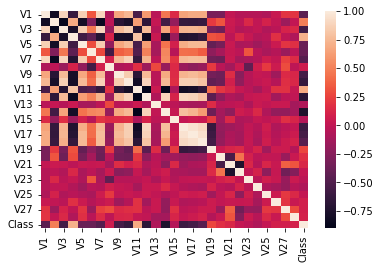

In [13]:
sns.heatmap(balanced_df.drop(['Time', 'Amount'], axis='columns').corr())

## 3.C Multi-layer Perceptron (MLP) Classifier

According to Scikit-Learn.org (n.d. a), MLPClassifier can automatically set
aside a portion of training data as validation set for early stopping (see
documentation for `early_stopping` and `validation_fraction` parameters).
Below, we enable `early_stopping` and set the `validation_fraction` to 0.2.

Per the assignment hint: change the loss function from mse/mae to something for
binary classification.  However, Scikit-Learn.org (n.d. b) describes the
mathematical formulation for binary classification as utilizing the logistic
function to obtain output values between zero and one.  Outputs greater than
or equal to 0.5 are assigned to the positive class, and the rest to the
negative class.

$$
g(z) = \frac{1}{1 + e^{-z}}
$$

We also know the following about the default MLPClassifier:

| Attribute             | Default                               |
:-----------------------|:--------------------------------------|
| `hidden_layer_sizes`  | `(100,)`                              |
| `activation`          | `relu`                                |
| `solver`              | `adam` (adaptive momentum estimation) |
| `learning_rate_init`  | `0.001` (constant)                    |

### 3.C.1 MLP Using Imbalanced Data

Utilizing imbalanced data, the MLPClassifier is able to achieve an accuracy
score of 99.9%.  However, the false negative case (incorrectly labeling
fraud as legitimate) is particularly damaging to both consumers and financial
institutions.  Using *recall* seems more appropriate, but a recall score of
only 68.4% is not great.


In [14]:
model = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(200, 100),
                                             early_stopping=True,
                                             random_state=RANDOM_SEED,
                                             validation_fraction=0.2)  

_ = model.fit(Xt_train, y_train)

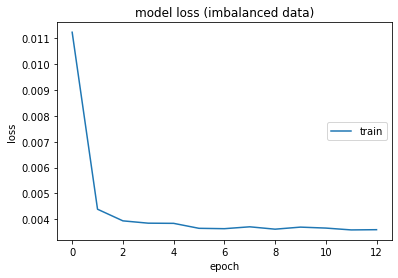

In [15]:
# summarize history for loss
plt.plot(model.loss_curve_)
plt.title('model loss (imbalanced data)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='center right')
plt.show()

2022-02-14 00:20:36 - INFO   -   MSDS-680 - Accuracy: 99.93%.  Precision: 87.01%.  Recall: 68.37%.  F1 Score: 76.57%


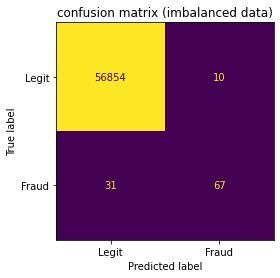

In [16]:
y_pred = model.predict(Xt_test)

# Print performance metrics
accuracy    = sklearn.metrics.accuracy_score(y_test, y_pred)
precision   = sklearn.metrics.precision_score(y_test, y_pred)
recall      = sklearn.metrics.recall_score(y_test, y_pred)
f1          = sklearn.metrics.f1_score(y_test, y_pred)

LOGGER.info(f'Accuracy: {accuracy:.2%}.  Precision: {precision:.2%}.  Recall: {recall:.2%}.  F1 Score: {f1:.2%}')

# Display the confusion matrix
cmat = sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_test,
                                                               y_pred=y_pred,
                                                               colorbar=False,
                                                               display_labels=['Legit', 'Fraud'])
_ = cmat.ax_.set_title('confusion matrix (imbalanced data)')


### 3.C.2 MLP Using Balanced Data

The effect of balanced vs imbalanced data wasn't clear to me prior to this
experiment.  I incorrectly assumed that the result would be the same as long as
the ratios were maintained between balanaced and imbalanced data.

However, utilizing balanced data, the MLPClassifier achieves the same accuracy
score of 99.9% but a greatly improved recall score of 91.8%!

This illustrates that, when using the imbalanced data, the model was able to
achieve a seemingly good accuracy score by guessing the majority case.


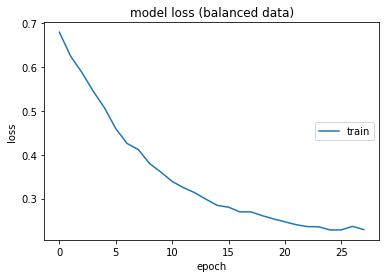

In [17]:
model = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(200, 100),
                                             early_stopping=True,
                                             random_state=RANDOM_SEED,
                                             validation_fraction=0.2)  

model.fit(Xt_balanced_train, y_balanced_train)

# summarize history for loss
plt.plot(model.loss_curve_)
plt.title('model loss (balanced data)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='center right')
plt.show()

2022-02-14 00:20:38 - INFO   -   MSDS-680 - Accuracy: 99.93%.  Precision: 98.89%.  Recall: 91.75%.  F1 Score: 95.19%


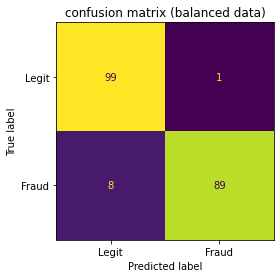

In [18]:
y_balanced_pred = model.predict(Xt_balanced_test)

# Print performance metrics
accuracy    = sklearn.metrics.accuracy_score(y_test, y_pred)
precision   = sklearn.metrics.precision_score(y_balanced_test, y_balanced_pred)
recall      = sklearn.metrics.recall_score(y_balanced_test, y_balanced_pred)
f1          = sklearn.metrics.f1_score(y_balanced_test, y_balanced_pred)

LOGGER.info(f'Accuracy: {accuracy:.2%}.  Precision: {precision:.2%}.  Recall: {recall:.2%}.  F1 Score: {f1:.2%}')

# Display the confusion matrix
cmat = sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_balanced_test,
                                                               y_pred=y_balanced_pred,
                                                               colorbar=False,
                                                               display_labels=['Legit', 'Fraud'])

_ = cmat.ax_.set_title('confusion matrix (balanced data)')


## 3.D Keras Neural Net

### 3.D.1 Hypermodel Construction

Now that we are using a Keras neural network, we heed the assignment hint:
change the loss function from mse/mae to something for binary classification
(`binary_crossentropy`).

Below, we use KerasTuner to perform a search for the best combination of
hyper-parameters for the sequential neural network.

* Layer 1 is a Dense (fully connected) 
    * `input_dim` implicitly creates an `InputLayer` for the correct number of
       features
    * The output dimension (`units`) and activation function (`activation`)
      are tuned hyper-parameters
* Layer 2 is a Dropout layer, which randomly sets inputs to 0 in
  order to avoid over-fitting
* Layer 3 is a Dense layer with output dimension (`units`) and activation
  function (`activation`) automatically
* Layer 4 is another Dropout layer
* Layer 5 is a Dense layer
    * `units` is set to `1` to establish binary output
    * The activation function (`activation`) is `sigmoid` (vice being a tuned
      parameter) such that the output will range from `0` to `1`


In [19]:
def create_model(hp):
    ''' Creates a model utilizing the hyper-parameters specified by "hp" '''
    activation_1    = hp.get('hparam/activation_1')
    activation_2    = hp.get('hparam/activation_2')
    units_1         = hp.get('hparam/units_1')
    units_2         = hp.get('hparam/units_2')

    model = keras.models.Sequential()
    model.add(keras.layers.Dense(units = units_1, activation = activation_1, input_dim = 28))
    model.add(keras.layers.Dropout(0.05, seed=RANDOM_SEED))
    model.add(keras.layers.Dense(units = units_2, activation = activation_2))
    model.add(keras.layers.Dropout(0.05, seed=RANDOM_SEED))
    model.add(keras.layers.Dense(units = 1, activation = 'sigmoid'))

    model.compile(optimizer = 'adam',
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy'])
    
    return model

# Perform a search for the best combination of model hyper-parameters as
# specified by the following constraints:
hp = kt.HyperParameters()
hp.Choice('hparam/activation_1', values=['relu', 'sigmoid', 'tanh'])
hp.Choice('hparam/activation_2', values=['relu', 'sigmoid', 'tanh'])
hp.Choice('hparam/units_1', values=[8**n for n in range(1, 5)])
hp.Choice('hparam/units_2', values=[8**n for n in range(1, 5)])

tuner = kt.Hyperband(create_model,
                     objective='val_accuracy',
                     max_epochs=MAX_EPOCHS,
                     factor=3,
                     hyperparameters=hp,
                     hyperband_iterations=3,
                     allow_new_entries=False,
                     seed=RANDOM_SEED,
                     directory=os.path.dirname(KERAS_PROJECT_PATH),
                     project_name=os.path.basename(KERAS_PROJECT_PATH),
                     overwrite=True)

2022-02-14 00:20:39.013738: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-14 00:20:39.013835: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-14 00:20:39.013870: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-dev): /proc/driver/nvidia/version does not exist
2022-02-14 00:20:39.014391: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 3.D.2 Hyper-parameter Search

Keras models allow validation data to be passed to the fit function to
calculate the accuracy.  According to the Keras API documentation, the
`validation_data` parameter is

        Data on which to evaluate the loss and any model metrics at the end of
        each epoch. The model will not be trained on this data

We use this mechanism below. 

In [20]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                           patience=10)

tuner.search(Xt_balanced_train, y_balanced_train,
             validation_data=(Xt_balanced_test, y_balanced_test),
             epochs=MAX_EPOCHS,
             callbacks=[stop_early],
             batch_size=KERAS_BATCH_SIZE,
             verbose=0)

2022-02-14 00:20:39.632559: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


INFO:tensorflow:Oracle triggered exit


2022-02-14 00:25:52 - INFO   - tensorflow - Oracle triggered exit


In [21]:
best_hps = tuner.get_best_hyperparameters()[0]

for hparam in best_hps.values:
    if hparam.startswith('hparam/'):
        LOGGER.info(f'Best value for {hparam:.<25} {best_hps.get(hparam)}')


2022-02-14 00:25:52 - INFO   -   MSDS-680 - Best value for hparam/activation_1...... tanh
2022-02-14 00:25:52 - INFO   -   MSDS-680 - Best value for hparam/activation_2...... relu
2022-02-14 00:25:52 - INFO   -   MSDS-680 - Best value for hparam/units_1........... 64
2022-02-14 00:25:52 - INFO   -   MSDS-680 - Best value for hparam/units_2........... 4096


### 3.D.3 Epoch Optimization

In [22]:
# Build the model with the optimal hyperparameters and train it for MAX_EPOCHS
# to determine the optimal number of epochs to avoid over-fitting
model   = tuner.hypermodel.build(best_hps)
history = model.fit(Xt_balanced_train, y_balanced_train,
                    epochs=MAX_EPOCHS,
                    validation_data=(Xt_balanced_test, y_balanced_test),
                    batch_size=KERAS_BATCH_SIZE,
                    verbose=0)

best_validation_accuracy    = max(history.history['val_accuracy'])
best_num_epochs             = history.history['val_accuracy'].index(best_validation_accuracy) + 1

LOGGER.info(f'Best epoch:{best_num_epochs} ({best_validation_accuracy:.2%})')


2022-02-14 00:25:57 - INFO   -   MSDS-680 - Best epoch:20 (97.97%)


### 3.D.4 Best Model, Best Epoch

The plots below demostrate that the validation accuracy closely tracks the
training accuracy.

While experimenting with Keras and the KerasTuner, it was observed that the
batch size influenced the smoothness of the curve (higher batch sizes yielded
smoother curves).  However, a batch size over ~200 greatly impacted the
run-time performance of the model and produced TensorFlow warnings.  Therefore,
the default batch size is set to 150 (above).

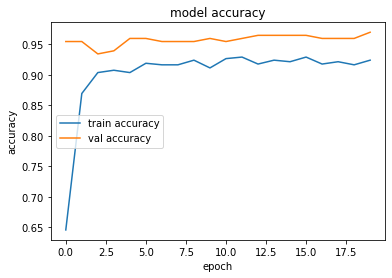

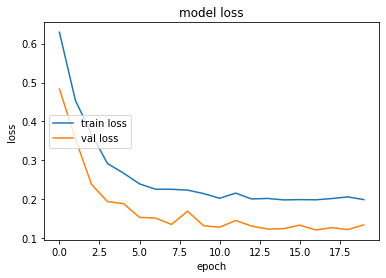

In [23]:
hypermodel = tuner.hypermodel.build(best_hps)

history = hypermodel.fit(Xt_balanced_train, y_balanced_train,
                         epochs=best_num_epochs,
                         validation_data=(Xt_balanced_test, y_balanced_test),
                         batch_size=KERAS_BATCH_SIZE,
                         verbose=0)
                         
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy'], loc='center left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='center left')
plt.show()


2022-02-14 00:26:00 - INFO   -   MSDS-680 - Accuracy: 96.95%.  Precision: 97.89%.  Recall: 95.88%.  F1 Score: 96.88%


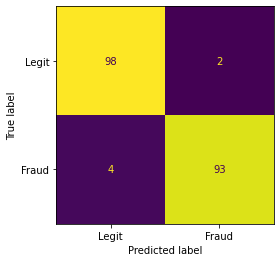

In [24]:
hypery_balanced_pred = hypermodel.predict(Xt_balanced_test).flatten()
hypery_balanced_pred = np.where(hypery_balanced_pred >= 0.5, 1, 0)

# Print performance metrics
accuracy    = sklearn.metrics.accuracy_score(y_balanced_test, hypery_balanced_pred)
precision   = sklearn.metrics.precision_score(y_balanced_test, hypery_balanced_pred)
recall      = sklearn.metrics.recall_score(y_balanced_test, hypery_balanced_pred)
f1          = sklearn.metrics.f1_score(y_balanced_test, hypery_balanced_pred)


LOGGER.info(f'Accuracy: {accuracy:.2%}.  Precision: {precision:.2%}.  Recall: {recall:.2%}.  F1 Score: {f1:.2%}')

# Display the confusion matrix
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_balanced_test, y_pred=hypery_balanced_pred, colorbar=False, display_labels=['Legit', 'Fraud'])


# 4 Conclusion

On this particular run, the Keras neural network recall score exceeded the
MLPClassifier.  However, results have differed from run to run, indicating
that there are one or more places where RANDOM_SEED should be used in
order to produce consistent results.

# References

Kaggle.com (n.d.).  Credit card fraud detection.  Retrieved from https://www.kaggle.com/mlg-ulb/creditcardfraud/

Scikit-Learn.org (n.d. a)  MLPClassifier.  Retrieved from https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html?highlight=mlpclassifier#sklearn.neural_network.MLPClassifier

Scikit-Learn.org (n.d. b)  Neural network models (supervised).  Retrieved from https://scikit-learn.org/stable/modules/neural_networks_supervised.html

Valkov, V. (2017, June).  Credit Card Fraud Detection using Autoencoders in Keras — TensorFlow for Hackers (Part VII)  Retrieved from https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd